In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..") 
from src.preprocessing import Preprocessor

In [2]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

Could be interresting to have the aval and amount data...

In [3]:
weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")

There is a big sport event in the test data so could be good to add public event data but I can't find it. I might have to create it from scratch or scrap it on the web.

# 1. Preprocessing

In [4]:
df = champs_elysees_df.copy()

In [5]:
preprocessor = Preprocessor(df)
preprocessed_df = preprocessor.preprocess_all(holidays_df=holidays_df, weather_df=weather_df)

c:\Users\clemm\Documents\CentraleSupelec\IA\Datathon-BCG\notebooks\..\src\preprocessing.py:138: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour_time'] = df[datetime_col].dt.floor('H')
c:\Users\clemm\Documents\CentraleSupelec\IA\Datathon-BCG\notebooks\..\src\preprocessing.py:139: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_df['hour_time'] = weather_df['time'].dt.floor('H')


In [6]:
preprocessed_df.columns

Index(['Identifiant arc', 'Libelle', 'Débit horaire', 'Taux d'occupation',
       'Etat trafic', 'Identifiant noeud amont', 'Libelle noeud amont',
       'Identifiant noeud aval', 'Libelle noeud aval', 'Etat arc',
       'Date debut dispo data', 'Date fin dispo data', 'geo_point_2d',
       'geo_shape', 'date', 'hour', 'year', 'month', 'weekday', 'is_weekend',
       'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin',
       'month_cos', 'day_of_year', 'dayofyear_sin', 'dayofyear_cos',
       'is_holiday', 'holiday_name', 'time', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'precipitation (mm)',
       'wind_speed_10m (km/h)', 'weather_code (wmo code)',
       'surface_pressure (hPa)', 'cloud_cover (%)',
       'apparent_temperature (°C)', 'rain (mm)'],
      dtype='object')

In [7]:
preprocessed_df[preprocessed_df["is_holiday"]==True]

,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,time,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),apparent_temperature (°C),rain (mm)
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2024-10-18 00:00:00,4264,AV_Champs_Elysees,544.0,7.96611,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-18 01:00:00,4264,AV_Champs_Elysees,557.0,6.08556,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-18 02:00:00,4264,AV_Champs_Elysees,477.0,5.81222,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-18 03:00:00,4264,AV_Champs_Elysees,366.0,3.94278,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-18 04:00:00,4264,AV_Champs_Elysees,352.0,3.42278,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-01 20:00:00,4264,AV_Champs_Elysees,909.0,25.62834,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,2025-11-01 20:00:00,13.1,83.0,0.0,13.9,3.0,1006.7,100.0,11.2,0.0
2025-11-01 21:00:00,4264,AV_Champs_Elysees,961.0,24.31667,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,2025-11-01 21:00:00,12.8,85.0,0.0,14.1,0.0,1006.5,2.0,10.9,0.0
2025-11-01 22:00:00,4264,AV_Champs_Elysees,954.0,25.56722,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,2025-11-01 22:00:00,12.5,85.0,0.0,15.6,0.0,1006.4,14.0,10.2,0.0


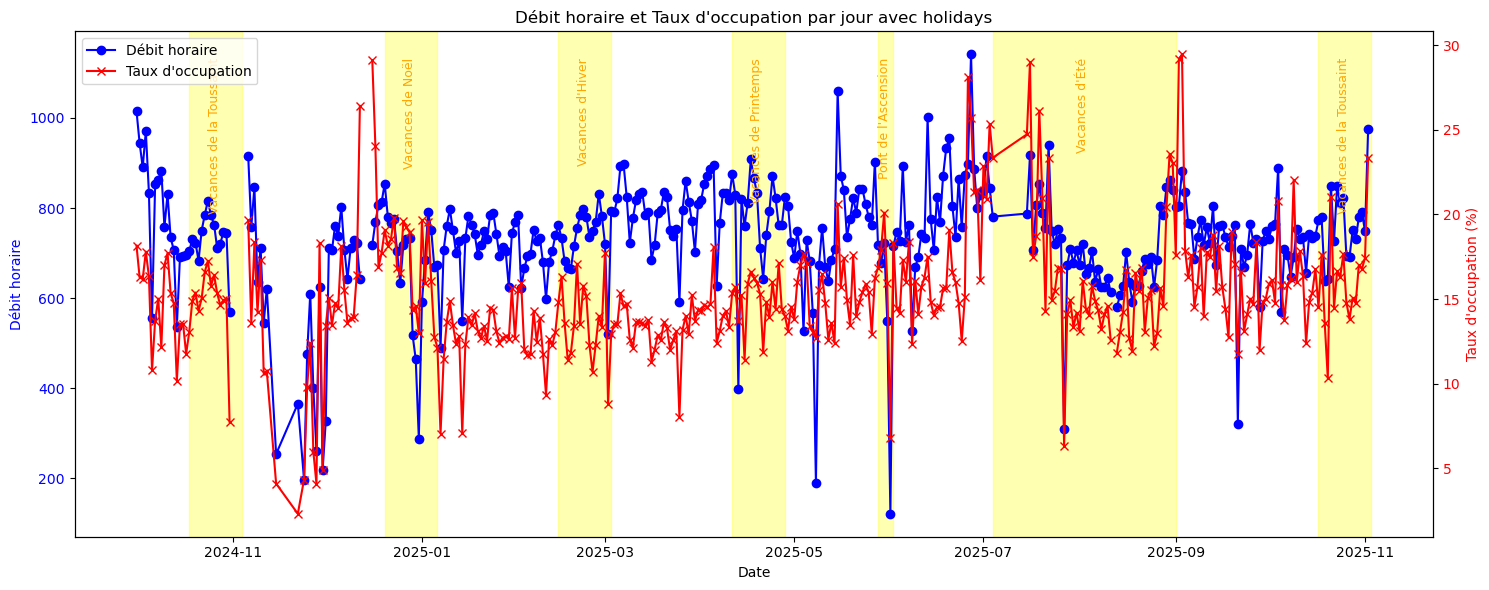

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Assure-toi que 'date' est en datetime.date
df['date'] = pd.to_datetime(df['date'])

# Grouper par date pour tracer une valeur moyenne par jour
daily_df = df.groupby('date').agg({
    'Débit horaire': 'mean',
    'Taux d\'occupation': 'mean',
    'holiday_name': 'first'  # récupère le nom de la holiday si présent
}).reset_index()

# Fusionner les périodes de vacances consécutives
holiday_periods = []
current_name = None
start_date = None

for idx, row in daily_df.iterrows():
    name = row['holiday_name']
    if pd.notna(name):
        if current_name != name:  # nouvelle holiday
            if current_name is not None:
                holiday_periods.append((start_date, prev_date, current_name))
            current_name = name
            start_date = row['date']
        prev_date = row['date']
    else:
        if current_name is not None:
            holiday_periods.append((start_date, prev_date, current_name))
            current_name = None
            start_date = None
if current_name is not None:
    holiday_periods.append((start_date, prev_date, current_name))

# Plot
fig, ax1 = plt.subplots(figsize=(15,6))

# Débit horaire
ax1.plot(daily_df['date'], daily_df['Débit horaire'], color='blue', marker='o', label='Débit horaire')
ax1.set_xlabel('Date')
ax1.set_ylabel('Débit horaire', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Taux d'occupation
ax2 = ax1.twinx()
ax2.plot(daily_df['date'], daily_df['Taux d\'occupation'], color='red', marker='x', label='Taux d\'occupation')
ax2.set_ylabel('Taux d\'occupation (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Ajouter des blocs pour les vacances
for start, end, name in holiday_periods:
    ax1.axvspan(start, end + pd.Timedelta(days=1), color='yellow', alpha=0.3)
    ax1.text(start + (end - start)/2, ax1.get_ylim()[1]*0.95, name, rotation=90,
             verticalalignment='top', fontsize=9, color='orange', ha='center')

# Légende
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title("Débit horaire et Taux d'occupation par jour avec holidays")
plt.tight_layout()
plt.show()
